In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Carga do Dataset

In [2]:
# Lê o arquivo
dataset = pd.read_csv('https://raw.githubusercontent.com/franciscoprado/estrelAI/main/api/MachineLearning/data/cleaned_star_data.csv', delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3042,0.000500,0.1542,16.60,0,Red,M
1,2600,0.000300,102.0000,18.70,0,Red,M
2,2800,0.000200,0.0000,16.65,0,Red,M
3,1939,0.000138,103.0000,20.06,0,Red,M
4,2840,0.000000,0.1100,16.98,0,Red,M


## Separação em conjunto de treino e conjunto de teste com holdout

In [3]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:4]
y = array[:,4]
y = y.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.685789 (0.078209)
CART: 0.973684 (0.035306)
NB: 0.743421 (0.054965)
SVM: 0.377105 (0.090933)


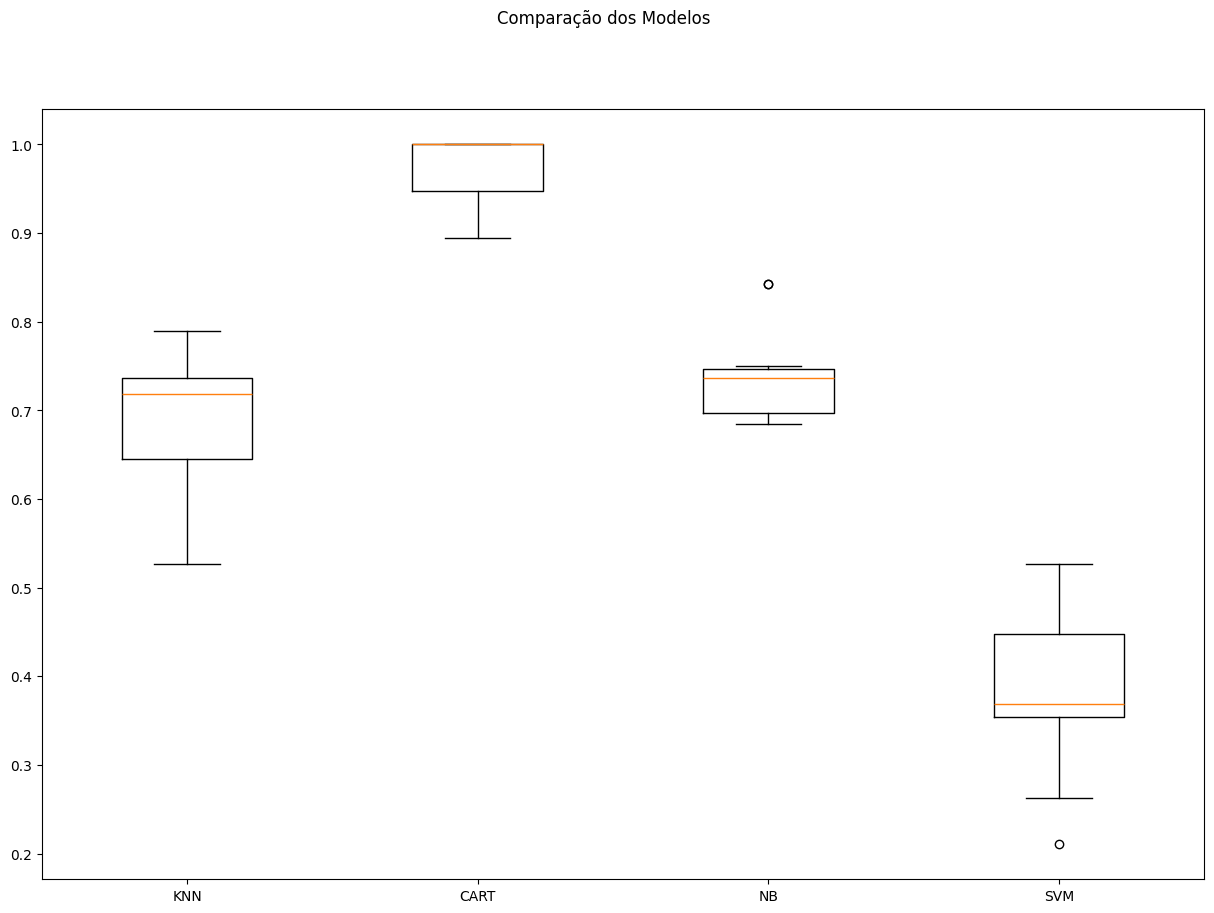

In [4]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.686 (0.078)
CART-orig: 0.974 (0.035)
NB-orig: 0.743 (0.055)
SVM-orig: 0.377 (0.091)
KNN-padr: 0.743 (0.102)
CART-padr: 0.974 (0.035)
NB-padr: 0.764 (0.058)
SVM-padr: 0.686 (0.059)
KNN-norm: 0.727 (0.091)
CART-norm: 0.979 (0.026)
NB-norm: 0.770 (0.058)
SVM-norm: 0.680 (0.051)


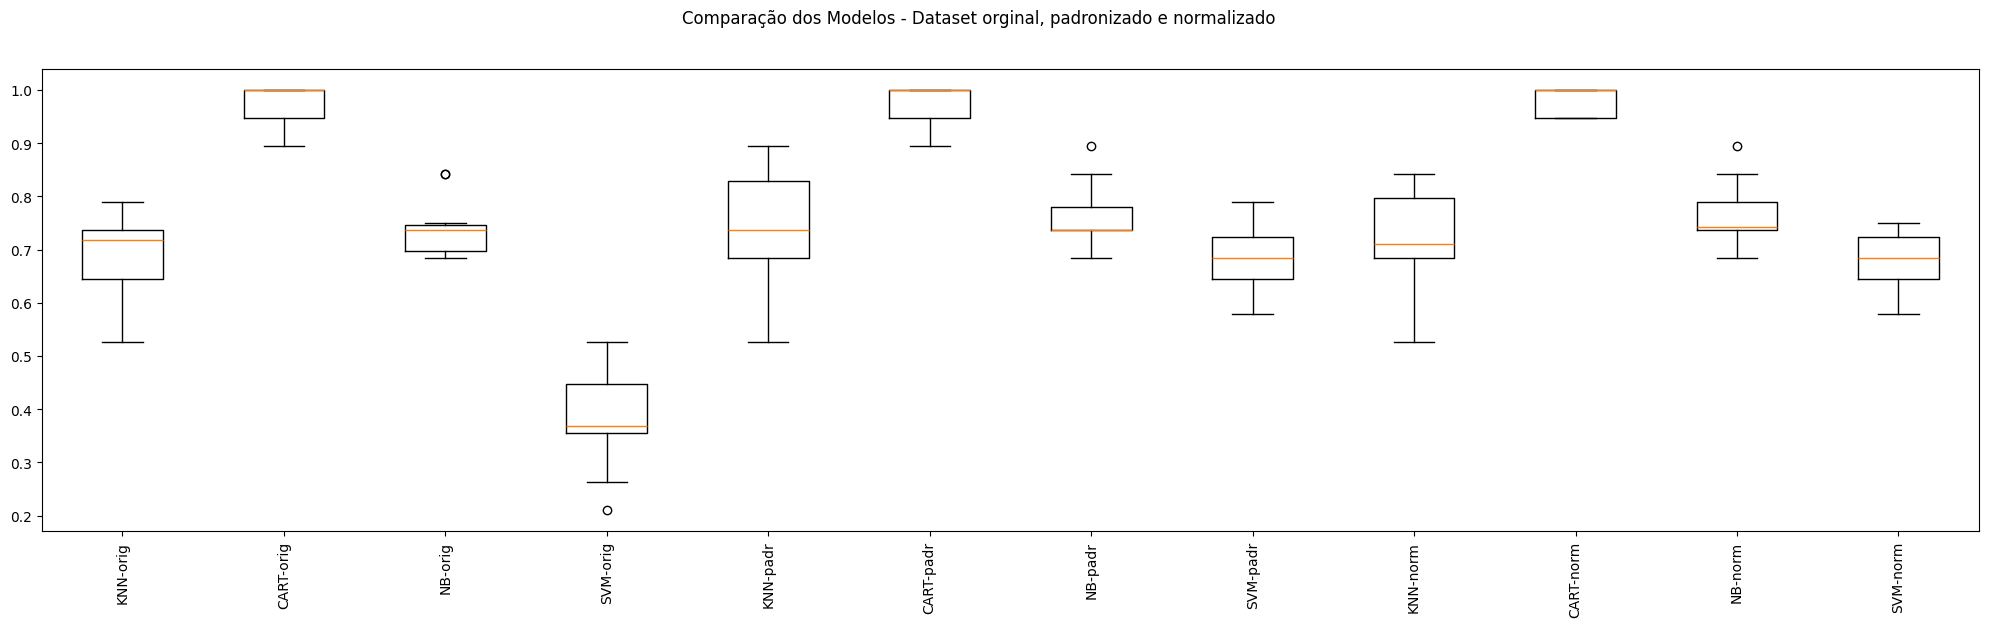

In [5]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [6]:
# Tuning do CART

np.random.seed(7)  # definindo uma semente global para este bloco

pipelines = []
pipeline = None
best_accuracy = 0.0

# Definindo os componentes do pipeline
cart = ('CART', DecisionTreeClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('cart-orig', Pipeline(steps=[cart])))
pipelines.append(('cart-padr', Pipeline(steps=[standard_scaler, cart])))
pipelines.append(('cart-norm', Pipeline(steps=[min_max_scaler, cart])))

param_grid = {
    'max_depth': [5, 10, 20,],
    'min_samples_split': [20, 40, 60, 80],
    'min_impurity_decrease': [0.0001, 0.0005, 0.001, 0.005, 0.01]
}

# Prepara e executa o fit
for name, model in pipelines:
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=1)
    grid_result = grid_search.fit(X_train, y_train)
    print("Melhor: %f com %s" %
          (grid_result.best_score_, grid_result.best_params_))
    model.fit(X_train, y_train)

    if grid_search.best_score_ >= best_accuracy:
        best_accuracy = grid_search.best_score_
        pipeline = model

Melhor: 0.968421 com {'max_depth': 5, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}
Melhor: 0.968421 com {'max_depth': 5, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}
Melhor: 0.968421 com {'max_depth': 5, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}


## Finalização do Modelo

In [7]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = DecisionTreeClassifier()
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9583333333333334


### Gerando os arquivos .pkl e datasets de testes

In [8]:
# Salvando o modelo
model_filename = 'cart_estrelas_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'minmax_scaler_estrelas.pkl'
with open("../scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
    
# Salvando o pipeline
pipeline_filename = 'cart_estrelas_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)
    
# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-3])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-3]])
X_test_df.to_csv("../data/X_test_dataset_estrelas.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_estrelas.csv", index=False)

In [9]:
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

DecisionTreeClassifier()

## Simulando a aplicação do modelo em dados não vistos

In [10]:
# Novos dados - não sabemos a classe!
data = {'temperature':  [3042, 3441, 3535],
        'luminosity':  [0.0005, 39, 195000],
        'radius':  [0.1542, 351, 1546],
        'absolute_magnitude':  [16.6, 11.18, 13.21],
        }

atributos = ['temperature',
             'luminosity',
             'radius',
             'absolute_magnitude']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:, 0:4].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-0.77284171 -0.58823075 -0.42696869 -0.05037709]
 [-0.73107776 -0.5880114  -0.06185096 -0.05297124]
 [-0.72123864  0.5085184   1.18176    -0.05199963]]


In [11]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 1. 5.]
